In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import ResNet50

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
strategy = tf.distribute.get_strategy()
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

2025-07-31 17:30:36.096743: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753983036.291494      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753983036.344239      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Dataset Configuration
DATASET_PATH = r"/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled"
IMG_SIZE = (112, 112)  # Standard LFW image size
IMG_CHANNELS = 3

class LFWDatasetProcessor:
    def __init__(self, dataset_path, img_size=(112, 112)):
        self.dataset_path = dataset_path
        self.img_size = img_size
        self.person_images = {}
        self.person_list = []
        
    def load_dataset(self, min_images_per_person=2):
        """Load dataset and organize by person"""
        print("Loading LFW dataset...")
        
        for person_name in os.listdir(self.dataset_path):
            person_path = os.path.join(self.dataset_path, person_name)
            
            if os.path.isdir(person_path):
                images = []
                for img_file in os.listdir(person_path):
                    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        img_path = os.path.join(person_path, img_file)
                        images.append(img_path)
                
                # Only include persons with at least min_images_per_person images
                if len(images) >= min_images_per_person:
                    self.person_images[person_name] = images
                    self.person_list.append(person_name)
        
        print(f"Loaded {len(self.person_list)} persons with {sum(len(imgs) for imgs in self.person_images.values())} total images")
        return self.person_images
    
    def preprocess_image(self, img_path):
        """Load and preprocess a single image"""
        try:
            # Load image
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Resize to target size
            img = cv2.resize(img, self.img_size)
            
            # Normalize to [0, 1]
            img = img.astype(np.float32) / 255.0
            
            return img
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            return None
    
    def create_pairs(self, num_pairs=10000):
        """Create positive and negative pairs for training"""
        pairs = []
        labels = []
        
        print(f"Creating {num_pairs} pairs...")
        
        for i in range(num_pairs):
            if i % 2 == 0:  # Create positive pair
                # Select a random person with at least 2 images
                person = random.choice([p for p in self.person_list if len(self.person_images[p]) >= 2])
                img_paths = self.person_images[person]
                
                # Select two different images of the same person
                img1_path, img2_path = random.sample(img_paths, 2)
                
                img1 = self.preprocess_image(img1_path)
                img2 = self.preprocess_image(img2_path)
                
                if img1 is not None and img2 is not None:
                    pairs.append([img1, img2])
                    labels.append(1)  # Same person
                
            else:  # Create negative pair
                # Select two different persons
                person1, person2 = random.sample(self.person_list, 2)
                
                img1_path = random.choice(self.person_images[person1])
                img2_path = random.choice(self.person_images[person2])
                
                img1 = self.preprocess_image(img1_path)
                img2 = self.preprocess_image(img2_path)
                
                if img1 is not None and img2 is not None:
                    pairs.append([img1, img2])
                    labels.append(0)  # Different persons
            
            if (i + 1) % 1000 == 0:
                print(f"Created {i + 1} pairs...")
        
        return np.array(pairs), np.array(labels)

# Initialize dataset processor
dataset_processor = LFWDatasetProcessor(DATASET_PATH, IMG_SIZE)

In [3]:
def create_base_network(input_shape):
    """Create the base network for feature extraction"""
    with strategy.scope():
        # Use ResNet50 as backbone with pre-trained weights
        base_model = ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape
        )
        
        # Fine-tune from the 5th block onwards
        # for layer in base_model.layers[:-20]:
        #     layer.trainable = False
    
        # Add custom layers on top
        x = base_model.output
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(1024, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(512, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=1), output_shape=(128,), name='l2_normalize')(x)  # L2 normalization
        
        model = Model(inputs=base_model.input, outputs=x)
    return model

# Model configuration
input_shape = (*IMG_SIZE, IMG_CHANNELS)
print(f"Input shape: {input_shape}")

print("Base network for feature extraction ready!")

Input shape: (112, 112, 3)
Base network for feature extraction ready!


In [4]:
# Load dataset
person_images = dataset_processor.load_dataset(min_images_per_person=2)

# Show dataset statistics
total_persons = len(person_images)
total_images = sum(len(imgs) for imgs in person_images.values())
avg_images_per_person = total_images / total_persons

print(f"\nDataset Statistics:")
print(f"Total persons: {total_persons}")
print(f"Total images: {total_images}")
print(f"Average images per person: {avg_images_per_person:.2f}")

# Show some examples
print(f"\nTop 10 persons by number of images:")
sorted_persons = sorted(person_images.items(), key=lambda x: len(x[1]), reverse=True)
for i, (person, images) in enumerate(sorted_persons[:10]):
    print(f"{i+1}. {person}: {len(images)} images")

Loading LFW dataset...
Loaded 1680 persons with 9164 total images

Dataset Statistics:
Total persons: 1680
Total images: 9164
Average images per person: 5.45

Top 10 persons by number of images:
1. George_W_Bush: 530 images
2. Colin_Powell: 236 images
3. Tony_Blair: 144 images
4. Donald_Rumsfeld: 121 images
5. Gerhard_Schroeder: 109 images
6. Ariel_Sharon: 77 images
7. Hugo_Chavez: 71 images
8. Junichiro_Koizumi: 60 images
9. Jean_Chretien: 55 images
10. John_Ashcroft: 53 images


In [5]:
# Create training pairs (for evaluation purposes)
print("Creating training pairs...")
pairs, labels = dataset_processor.create_pairs(num_pairs=4000)

print(f"Created {len(pairs)} pairs")
print(f"Positive pairs (same person): {np.sum(labels)}")
print(f"Negative pairs (different persons): {len(labels) - np.sum(labels)}")

# Split into train and validation sets
train_pairs, val_pairs, train_labels, val_labels = train_test_split(
    pairs, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"\nTrain set: {len(train_pairs)} pairs")
print(f"Validation set: {len(val_pairs)} pairs")

# Function to visualize triplets
def visualize_triplets(triplets, num_triplets=4):
    """Visualize sample triplets (anchor, positive, negative)"""
    fig, axes = plt.subplots(3, num_triplets, figsize=(15, 9))
    
    for i in range(num_triplets):
        idx = random.randint(0, len(triplets) - 1)
        triplet = triplets[idx]
        
        # Anchor image
        axes[0, i].imshow(triplet[0])
        axes[0, i].set_title(f"Triplet {i+1} - Anchor")
        axes[0, i].axis('off')
        
        # Positive image (same person as anchor)
        axes[1, i].imshow(triplet[1])
        axes[1, i].set_title(f"Positive (Same Person)")
        axes[1, i].axis('off')
        
        # Negative image (different person)
        axes[2, i].imshow(triplet[2])
        axes[2, i].set_title(f"Negative (Different Person)")
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Triplet visualization function ready!")

Creating training pairs...
Creating 4000 pairs...
Created 1000 pairs...
Created 2000 pairs...
Created 3000 pairs...
Created 4000 pairs...
Created 4000 pairs
Positive pairs (same person): 2000
Negative pairs (different persons): 2000

Train set: 3200 pairs
Validation set: 800 pairs
Triplet visualization function ready!


In [6]:
# Prepare data for training (pairs for evaluation)
def prepare_data(pairs, labels):
    """Convert pairs to the format expected for evaluation"""
    left_images = np.array([pair[0] for pair in pairs])
    right_images = np.array([pair[1] for pair in pairs])
    return [left_images, right_images], labels

def prepare_triplet_data(triplets):
    """Convert triplets to the format expected by triplet network"""
    anchors = np.array([triplet[0] for triplet in triplets])
    positives = np.array([triplet[1] for triplet in triplets])
    negatives = np.array([triplet[2] for triplet in triplets])
    
    # Dummy labels (not used in triplet loss but required by Keras)
    labels = np.zeros(len(triplets))
    
    return [anchors, positives, negatives], labels

# Prepare validation data for evaluation
X_val, y_val = prepare_data(val_pairs, val_labels)

print(f"Validation data shapes:")
print(f"Left images: {X_val[0].shape}")
print(f"Right images: {X_val[1].shape}")
print(f"Labels: {y_val.shape}")

# Define callbacks for training optimization
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_siamese_resnet50_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("\nCallbacks configured:")
print("- EarlyStopping: Stops training if validation loss doesn't improve for 10 epochs")
print("- ModelCheckpoint: Saves the best triplet model based on validation loss")
print("- ReduceLROnPlateau: Reduces learning rate when validation loss plateaus")

Validation data shapes:
Left images: (800, 112, 112, 3)
Right images: (800, 112, 112, 3)
Labels: (800,)

Callbacks configured:
- EarlyStopping: Stops training if validation loss doesn't improve for 10 epochs
- ModelCheckpoint: Saves the best triplet model based on validation loss
- ReduceLROnPlateau: Reduces learning rate when validation loss plateaus


In [7]:
# ============================================================================
# TRIPLET LOSS IMPLEMENTATION AND TRAINING
# ============================================================================

def triplet_loss(y_true, y_pred, margin=0.5):
    """
    Triplet loss function for Siamese networks
    y_pred should contain [anchor, positive, negative] embeddings
    """
    # Split the predictions into anchor, positive, and negative
    anchor = y_pred[:, :128]  # First 128 dimensions
    positive = y_pred[:, 128:256]  # Next 128 dimensions  
    negative = y_pred[:, 256:]  # Last 128 dimensions
    
    # Calculate distances
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    
    # Triplet loss with margin
    loss = tf.maximum(0.0, pos_dist - neg_dist + margin)
    return tf.reduce_mean(loss)

class TripletDataGenerator:
    """Generate triplets for training"""
    
    def __init__(self, dataset_processor, batch_size=32):
        self.dataset_processor = dataset_processor
        self.batch_size = batch_size
        self.person_images = dataset_processor.person_images
        self.person_list = dataset_processor.person_list
        
    def generate_triplets(self, num_triplets=1000):
        """Generate triplets (anchor, positive, negative)"""
        triplets = []
        
        print(f"Generating {num_triplets} triplets...")
        
        for i in range(num_triplets):
            # Select anchor person (must have at least 2 images)
            anchor_person = random.choice([p for p in self.person_list 
                                         if len(self.person_images[p]) >= 2])
            
            # Select anchor and positive images from same person
            anchor_img_path, positive_img_path = random.sample(
                self.person_images[anchor_person], 2)
            
            # Select negative person (different from anchor)
            negative_person = random.choice([p for p in self.person_list 
                                           if p != anchor_person])
            negative_img_path = random.choice(self.person_images[negative_person])
            
            # Preprocess images
            anchor_img = self.dataset_processor.preprocess_image(anchor_img_path)
            positive_img = self.dataset_processor.preprocess_image(positive_img_path)
            negative_img = self.dataset_processor.preprocess_image(negative_img_path)
            
            if (anchor_img is not None and positive_img is not None and 
                negative_img is not None):
                triplets.append([anchor_img, positive_img, negative_img])
                
            if (i + 1) % 500 == 0:
                print(f"Generated {i + 1} triplets...")
        
        return np.array(triplets)

def create_triplet_network(input_shape):
    """Create triplet network architecture"""
    
    # Create base network for feature extraction
    base_network = create_base_network(input_shape)
    
    # Define inputs for anchor, positive, and negative
    anchor_input = Input(shape=input_shape, name='anchor_input')
    positive_input = Input(shape=input_shape, name='positive_input') 
    negative_input = Input(shape=input_shape, name='negative_input')
    
    # Generate embeddings using shared weights
    anchor_embedding = base_network(anchor_input)
    positive_embedding = base_network(positive_input)
    negative_embedding = base_network(negative_input)
    
    # Concatenate embeddings for loss calculation
    output = layers.Concatenate(name='triplet_output')([
        anchor_embedding, positive_embedding, negative_embedding])
    
    # Create triplet model
    triplet_model = Model(
        inputs=[anchor_input, positive_input, negative_input], 
        outputs=output)
    
    return triplet_model, base_network

# Training configuration
EPOCHS = 30
BATCH_SIZE = 32

# Create triplet network
print("Creating triplet network...")
triplet_model, base_network = create_triplet_network(input_shape)

# Compile triplet model
triplet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=triplet_loss
)

print("Triplet Network Architecture:")
triplet_model.summary()

print("\nTriplet loss implementation ready!")

Creating triplet network...


I0000 00:00:1753983101.560726      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Triplet Network Architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ anchor_input        │ (None, 112, 112,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive_input      │ (None, 112, 112,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative_input      │ (None, 112, 112,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 128)       │ 26,383,104 │ anchor_input[0][… │
│ (Functional)        │                   │            │ positive_input[0… │
│                     │                   │            │ negative_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ triplet_output      │ (None, 384)       │          0 │ functional[0][0], │
│ (Concatenate)       │                   │            │ functional[1][0], │
│                     │                   │            │ functional[2][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,383,104 (100.64 MB)

 Trainable params: 26,325,888 (100.43 MB)

 Non-trainable params: 57,216 (223.50 KB)


Triplet loss implementation ready!


Generating training triplets...
Generating 8000 triplets...
Generated 500 triplets...
Generated 1000 triplets...
Generated 1500 triplets...
Generated 2000 triplets...
Generated 2500 triplets...
Generated 3000 triplets...
Generated 3500 triplets...
Generated 4000 triplets...
Generated 4500 triplets...
Generated 5000 triplets...
Generated 5500 triplets...
Generated 6000 triplets...
Generated 6500 triplets...
Generated 7000 triplets...
Generated 7500 triplets...
Generated 8000 triplets...
Generating validation triplets...
Generating 2000 triplets...
Generated 500 triplets...
Generated 1000 triplets...
Generated 1500 triplets...
Generated 2000 triplets...

Triplet Training data shapes:
Anchors: (8000, 112, 112, 3)
Positives: (8000, 112, 112, 3)
Negatives: (8000, 112, 112, 3)

Sample triplets:


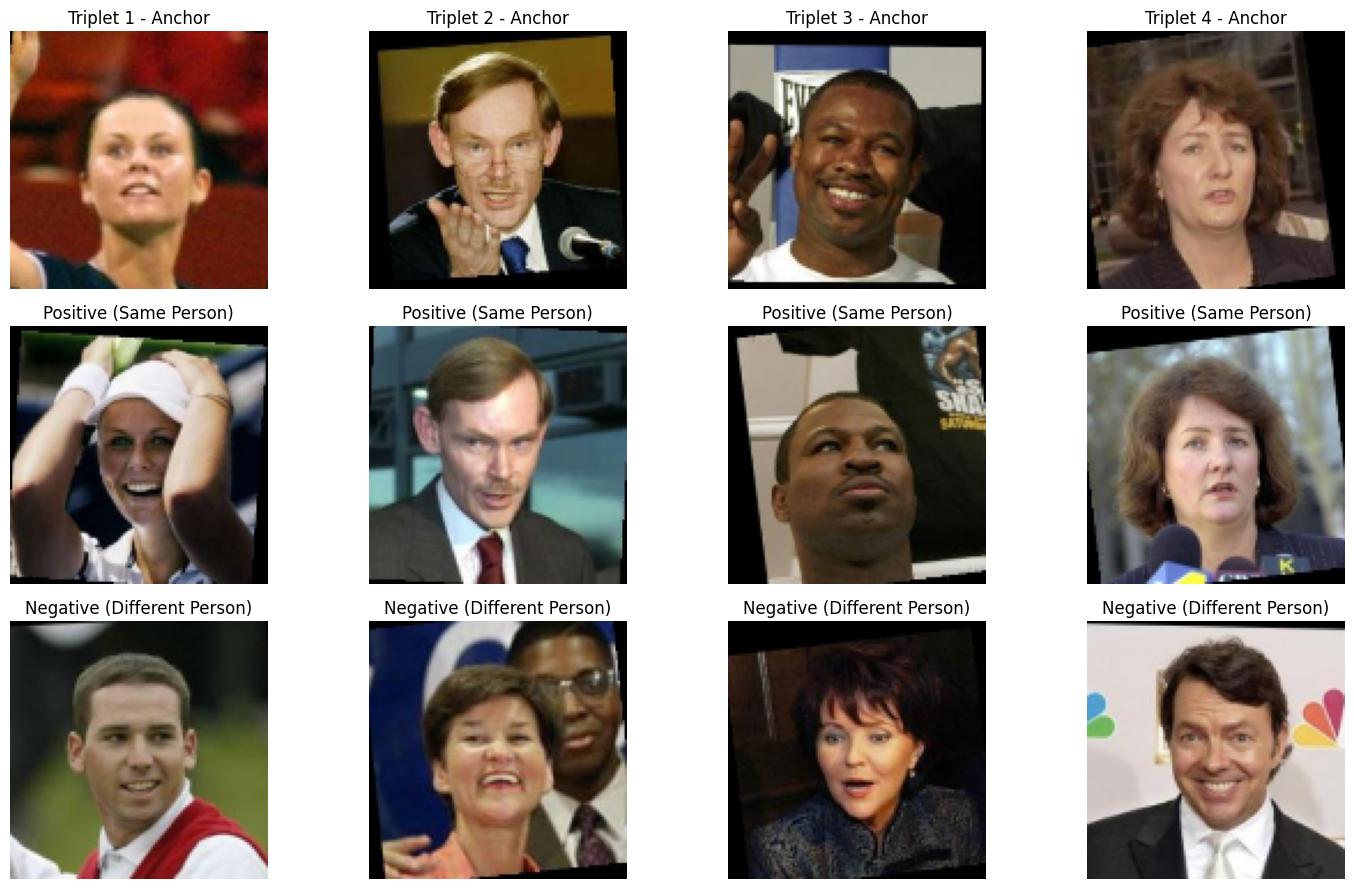


Starting triplet model training...
Epochs: 30
Batch size: 32
Loss function: Triplet Loss (margin=0.5)
Epoch 1/30


I0000 00:00:1753983263.838019      60 service.cc:148] XLA service 0x7a2f8c004650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753983263.839410      60 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753983272.666925      60 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753983306.314194      60 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.4509
Epoch 1: val_loss improved from inf to 0.43469, saving model to best_siamese_resnet50_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 189s 250ms/step - loss: 0.4506 - val_loss: 0.4347 - learning_rate: 1.0000e-04
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.2136
Epoch 2: val_loss improved from 0.43469 to 0.14350, saving model to best_siamese_resnet50_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 175ms/step - loss: 0.2134 - val_loss: 0.1435 - learning_rate: 1.0000e-04
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.1192
Epoch 3: val_loss improved from 0.14350 to 0.10635, saving model to best_siamese_resnet50_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 175ms/step - loss: 0.1191 - val_loss: 0.1064 - learning_rate: 1.0000e-04
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0697
Epoch 4: val_loss did not improve from 0.10635
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - loss: 0.0697 - val_lo

In [8]:
# Generate and prepare triplet training data
triplet_generator = TripletDataGenerator(dataset_processor, batch_size=32)

# Generate training and validation triplets
print("Generating training triplets...")
train_triplets = triplet_generator.generate_triplets(num_triplets=8000)

print("Generating validation triplets...")
val_triplets = triplet_generator.generate_triplets(num_triplets=2000)

# Prepare data for training
X_train_triplet, y_train_triplet = prepare_triplet_data(train_triplets)
X_val_triplet, y_val_triplet = prepare_triplet_data(val_triplets)

print(f"\nTriplet Training data shapes:")
print(f"Anchors: {X_train_triplet[0].shape}")
print(f"Positives: {X_train_triplet[1].shape}")
print(f"Negatives: {X_train_triplet[2].shape}")

# Visualize some sample triplets
print("\nSample triplets:")
visualize_triplets(train_triplets, num_triplets=4)

# Train triplet model
print("\nStarting triplet model training...")
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Loss function: Triplet Loss (margin=0.5)")

triplet_history = triplet_model.fit(
    X_train_triplet, y_train_triplet,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_triplet, y_val_triplet),
    callbacks=callbacks,
    verbose=1
)

print("\nTriplet model training completed!")

In [9]:
# Training visualization and evaluation functions for triplet model
def plot_training_history(history):
    """Plot training history"""
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Plot loss
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_title('Triplet Model Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

def evaluate_triplet_model(base_network, X_test_pairs, y_test_pairs, threshold=0.5):
    """Evaluate triplet model on pair data"""
    print("Evaluating triplet model...")
    
    # Extract embeddings for both images in each pair
    left_embeddings = base_network.predict(X_test_pairs[0])
    right_embeddings = base_network.predict(X_test_pairs[1])
    
    # Calculate Euclidean distances
    distances = np.sqrt(np.sum((left_embeddings - right_embeddings) ** 2, axis=1))
    
    # Convert distances to binary predictions
    predictions = (distances < threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_pairs, predictions)
    
    print(f"\nTriplet Model Evaluation (threshold={threshold}):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Average distance for same person: {distances[y_test_pairs == 1].mean():.4f}")
    print(f"Average distance for different persons: {distances[y_test_pairs == 0].mean():.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test_pairs, predictions, target_names=['Different', 'Same']))
    
    # Confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test_pairs, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Different', 'Same'], 
                yticklabels=['Different', 'Same'])
    plt.title('Triplet Model Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return accuracy, distances, predictions

def find_optimal_threshold_triplet(base_network, X_val_pairs, y_val_pairs):
    """Find optimal threshold for triplet model"""
    print("Finding optimal threshold for triplet model...")
    
    # Get embeddings
    left_embeddings = base_network.predict(X_val_pairs[0])
    right_embeddings = base_network.predict(X_val_pairs[1])
    distances = np.sqrt(np.sum((left_embeddings - right_embeddings) ** 2, axis=1))
    
    thresholds = np.arange(0.1, 3.0, 0.05)
    accuracies = []
    
    for threshold in thresholds:
        predictions = (distances < threshold).astype(int)
        accuracy = accuracy_score(y_val_pairs, predictions)
        accuracies.append(accuracy)
    
    best_threshold = thresholds[np.argmax(accuracies)]
    best_accuracy = max(accuracies)
    
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracies)
    plt.axvline(x=best_threshold, color='r', linestyle='--', 
                label=f'Best threshold: {best_threshold:.3f}')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('Triplet Model: Threshold vs Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"Optimal threshold: {best_threshold:.3f}")
    print(f"Best accuracy: {best_accuracy:.4f}")
    
    return best_threshold, best_accuracy

def test_on_new_pairs(dataset_processor, num_test_pairs=100):
    """Test model on new pairs"""
    print(f"Creating {num_test_pairs} test pairs...")
    
    # Create new test pairs
    test_pairs, test_labels = dataset_processor.create_pairs(num_pairs=num_test_pairs)
    X_test, y_test = prepare_data(test_pairs, test_labels)
    
    print(f"Test set: {len(test_pairs)} pairs")
    print(f"Positive pairs: {np.sum(test_labels)}")
    print(f"Negative pairs: {len(test_labels) - np.sum(test_labels)}")
    
    return X_test, y_test

print("Triplet model evaluation functions ready!")

Triplet model evaluation functions ready!


Plotting triplet model training history...


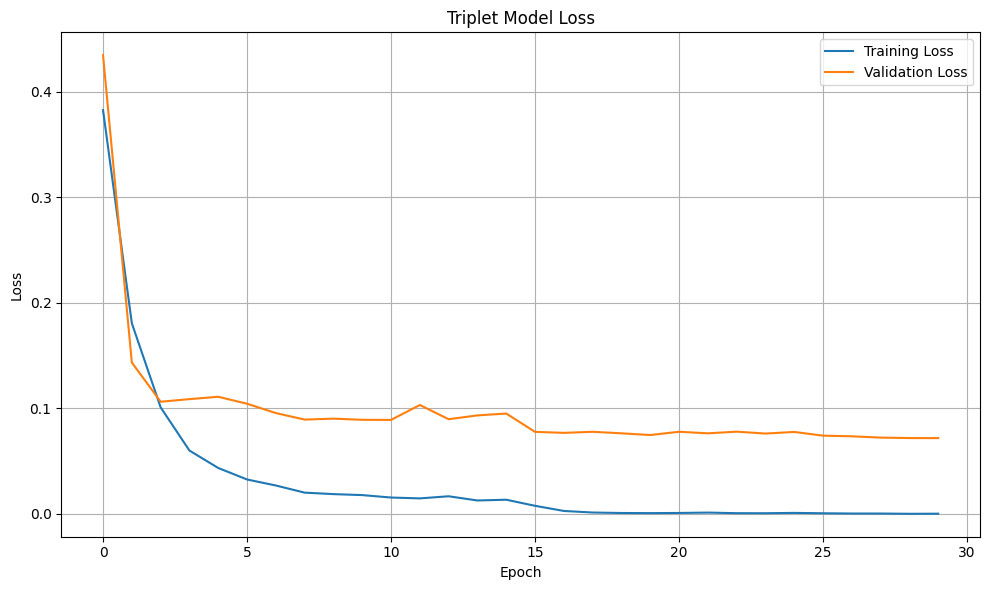

Finding optimal threshold for triplet model...
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


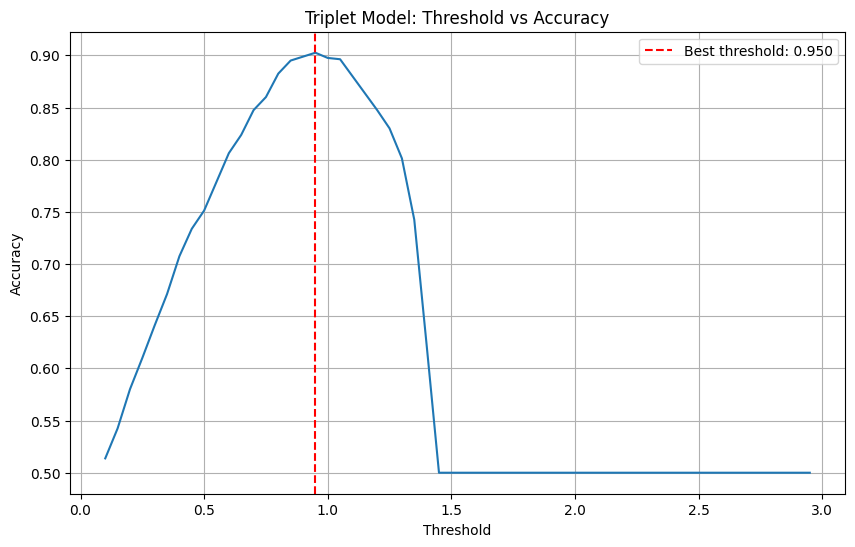

Optimal threshold: 0.950
Best accuracy: 0.9025

Evaluating triplet model on validation set...
Evaluating triplet model...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

Triplet Model Evaluation (threshold=0.9500000000000003):
Accuracy: 0.9025
Average distance for same person: 0.5021
Average distance for different persons: 1.2332

Classification Report:
              precision    recall  f1-score   support

   Different       0.92      0.88      0.90       400
        Same       0.88      0.93      0.90       400

    accuracy                           0.90       800
   macro avg       0.90      0.90      0.90       800
weighted avg       0.90      0.90      0.90       800



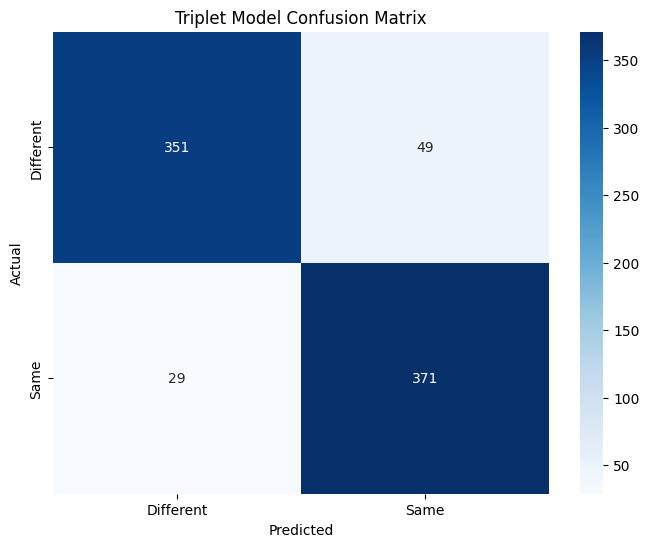


Creating test data for evaluation...
Creating 1000 test pairs...
Creating 1000 pairs...
Created 1000 pairs...
Test set: 1000 pairs
Positive pairs: 500
Negative pairs: 500

TRIPLET LOSS MODEL FINAL RESULTS:
Evaluating triplet model...
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

Triplet Model Evaluation (threshold=0.9500000000000003):
Accuracy: 0.8960
Average distance for same person: 0.4873
Average distance for different persons: 1.2099

Classification Report:
              precision    recall  f1-score   support

   Different       0.94      0.85      0.89       500
        Same       0.86      0.94      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



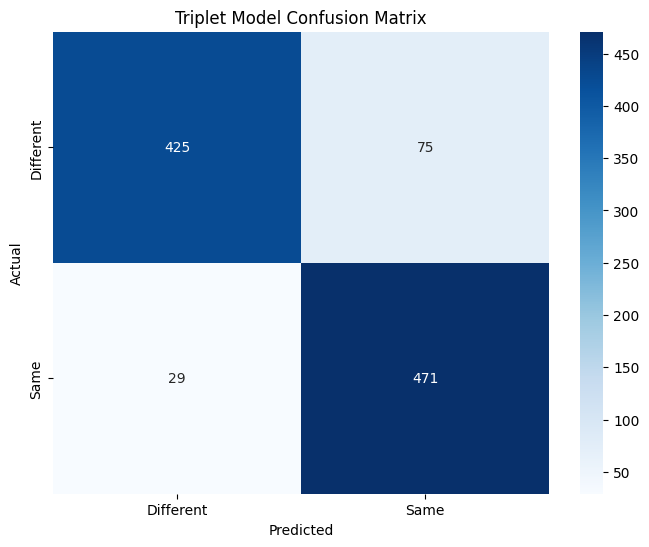


FINAL EVALUATION SUMMARY:
Triplet Loss Model Performance:
  - Validation Accuracy: 0.9025
  - Test Accuracy: 0.8960
  - Optimal Threshold: 0.950
  - Training Epochs: 30

DISTANCE ANALYSIS:
Same Person Distances:
  - Mean: 0.4873
  - Std: 0.2684
  - Min: 0.0367
  - Max: 1.3354

Different Person Distances:
  - Mean: 1.2099
  - Std: 0.2696
  - Min: 0.1154
  - Max: 1.4142

Distance Separation: 0.7226
Separation Quality: Good


In [10]:
# ============================================================================
# TRIPLET MODEL EVALUATION AND RESULTS
# ============================================================================

# Plot training history for triplet model
print("Plotting triplet model training history...")
plot_training_history(triplet_history)

# Find optimal threshold for triplet model
optimal_threshold_triplet, best_val_accuracy_triplet = find_optimal_threshold_triplet(
    base_network, X_val, y_val)

# Evaluate triplet model on validation set
print(f"\nEvaluating triplet model on validation set...")
val_accuracy_triplet, val_distances_triplet, val_predictions_triplet = evaluate_triplet_model(
    base_network, X_val, y_val, threshold=optimal_threshold_triplet)

# Create test data and evaluate model
print(f"\nCreating test data for evaluation...")
X_test_compare, y_test_compare = test_on_new_pairs(dataset_processor, num_test_pairs=1000)

# Evaluate triplet model on test set  
print(f"\n{'='*60}")
print("TRIPLET LOSS MODEL FINAL RESULTS:")
print(f"{'='*60}")
test_accuracy_triplet, test_distances_triplet, test_predictions_triplet = evaluate_triplet_model(
    base_network, X_test_compare, y_test_compare, threshold=optimal_threshold_triplet)

print(f"\n{'='*60}")
print("FINAL EVALUATION SUMMARY:")
print(f"{'='*60}")
print(f"Triplet Loss Model Performance:")
print(f"  - Validation Accuracy: {val_accuracy_triplet:.4f}")
print(f"  - Test Accuracy: {test_accuracy_triplet:.4f}")
print(f"  - Optimal Threshold: {optimal_threshold_triplet:.3f}")
print(f"  - Training Epochs: {len(triplet_history.history['loss'])}")

# Performance analysis
print(f"\n{'='*60}")
print("DISTANCE ANALYSIS:")
print(f"{'='*60}")
same_person_distances = test_distances_triplet[y_test_compare == 1]
diff_person_distances = test_distances_triplet[y_test_compare == 0]

print(f"Same Person Distances:")
print(f"  - Mean: {same_person_distances.mean():.4f}")
print(f"  - Std: {same_person_distances.std():.4f}")
print(f"  - Min: {same_person_distances.min():.4f}")
print(f"  - Max: {same_person_distances.max():.4f}")

print(f"\nDifferent Person Distances:")
print(f"  - Mean: {diff_person_distances.mean():.4f}")
print(f"  - Std: {diff_person_distances.std():.4f}")
print(f"  - Min: {diff_person_distances.min():.4f}")
print(f"  - Max: {diff_person_distances.max():.4f}")

separation = diff_person_distances.mean() - same_person_distances.mean()
print(f"\nDistance Separation: {separation:.4f}")
print(f"Separation Quality: {'Good' if separation > 0.5 else 'Moderate' if separation > 0.2 else 'Poor'}")

In [11]:
# ============================================================================
# DETAILED PERFORMANCE STATISTICS FOR POSITIVE AND NEGATIVE PAIRS
# ============================================================================

print("DETAILED PERFORMANCE STATISTICS:")

# Performance metrics for positive pairs (same person)
positive_mask = y_test_compare == 1
positive_predictions = test_predictions_triplet[positive_mask]
positive_distances = test_distances_triplet[positive_mask]
positive_correct = (positive_predictions == 1).sum()
positive_total = len(positive_predictions)
positive_accuracy = positive_correct / positive_total

print(f"\n📊 POSITIVE PAIRS (Same Person) Performance:")
print(f"  - Total Positive Pairs: {positive_total}")
print(f"  - Correctly Identified: {positive_correct}")
print(f"  - Incorrectly Identified: {positive_total - positive_correct}")
print(f"  - Accuracy (Sensitivity/Recall): {positive_accuracy:.4f} ({positive_accuracy*100:.2f}%)")
print(f"  - False Negative Rate: {1-positive_accuracy:.4f} ({(1-positive_accuracy)*100:.2f}%)")
print(f"  - Average Distance: {positive_distances.mean():.4f}")
print(f"  - Distance Std: {positive_distances.std():.4f}")
print(f"  - Distance Range: [{positive_distances.min():.4f}, {positive_distances.max():.4f}]")

# Performance metrics for negative pairs (different persons)
negative_mask = y_test_compare == 0
negative_predictions = test_predictions_triplet[negative_mask]
negative_distances = test_distances_triplet[negative_mask]
negative_correct = (negative_predictions == 0).sum()
negative_total = len(negative_predictions)
negative_accuracy = negative_correct / negative_total

print(f"\n📊 NEGATIVE PAIRS (Different Persons) Performance:")
print(f"  - Total Negative Pairs: {negative_total}")
print(f"  - Correctly Identified: {negative_correct}")
print(f"  - Incorrectly Identified: {negative_total - negative_correct}")
print(f"  - Accuracy (Specificity): {negative_accuracy:.4f} ({negative_accuracy*100:.2f}%)")
print(f"  - False Positive Rate: {1-negative_accuracy:.4f} ({(1-negative_accuracy)*100:.2f}%)")
print(f"  - Average Distance: {negative_distances.mean():.4f}")
print(f"  - Distance Std: {negative_distances.std():.4f}")
print(f"  - Distance Range: [{negative_distances.min():.4f}, {negative_distances.max():.4f}]")

# Additional metrics
precision = positive_correct / (positive_correct + (negative_total - negative_correct))
recall = positive_accuracy  # Same as sensitivity
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"\n📈 ADDITIONAL METRICS:")
print(f"  - Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"  - Recall (Sensitivity): {recall:.4f} ({recall*100:.2f}%)")
print(f"  - F1-Score: {f1_score:.4f}")
print(f"  - Specificity: {negative_accuracy:.4f} ({negative_accuracy*100:.2f}%)")

# Error analysis
false_negatives = positive_total - positive_correct
false_positives = negative_total - negative_correct

print(f"\n🔍 ERROR ANALYSIS:")
print(f"  - False Negatives (missed same person): {false_negatives}")
print(f"  - False Positives (incorrect same person): {false_positives}")
print(f"  - Total Errors: {false_negatives + false_positives}")
print(f"  - Error Rate: {(false_negatives + false_positives) / (positive_total + negative_total):.4f}")

# Distance threshold analysis
print(f"\n🎯 THRESHOLD ANALYSIS:")
print(f"  - Optimal Threshold: {optimal_threshold_triplet:.4f}")
print(f"  - Positive pairs below threshold: {(positive_distances < optimal_threshold_triplet).sum()}/{positive_total}")
print(f"  - Negative pairs above threshold: {(negative_distances >= optimal_threshold_triplet).sum()}/{negative_total}")

# Distribution overlap analysis
overlap_start = max(positive_distances.min(), negative_distances.min())
overlap_end = min(positive_distances.max(), negative_distances.max())
overlap_region = overlap_end - overlap_start if overlap_end > overlap_start else 0

print(f"\n📊 DISTANCE DISTRIBUTION OVERLAP:")
print(f"  - Overlap Region: [{overlap_start:.4f}, {overlap_end:.4f}]")
print(f"  - Overlap Size: {overlap_region:.4f}")
print(f"  - Overlap Percentage: {(overlap_region / (diff_person_distances.max() - same_person_distances.min())) * 100:.2f}%")

print(f"\n🎉 Triplet network training and evaluation completed successfully!")
print(f"✅ Model saved as: best_siamese_resnet50_model.keras")

DETAILED PERFORMANCE STATISTICS:

📊 POSITIVE PAIRS (Same Person) Performance:
  - Total Positive Pairs: 500
  - Correctly Identified: 471
  - Incorrectly Identified: 29
  - Accuracy (Sensitivity/Recall): 0.9420 (94.20%)
  - False Negative Rate: 0.0580 (5.80%)
  - Average Distance: 0.4873
  - Distance Std: 0.2684
  - Distance Range: [0.0367, 1.3354]

📊 NEGATIVE PAIRS (Different Persons) Performance:
  - Total Negative Pairs: 500
  - Correctly Identified: 425
  - Incorrectly Identified: 75
  - Accuracy (Specificity): 0.8500 (85.00%)
  - False Positive Rate: 0.1500 (15.00%)
  - Average Distance: 1.2099
  - Distance Std: 0.2696
  - Distance Range: [0.1154, 1.4142]

📈 ADDITIONAL METRICS:
  - Precision: 0.8626 (86.26%)
  - Recall (Sensitivity): 0.9420 (94.20%)
  - F1-Score: 0.9006
  - Specificity: 0.8500 (85.00%)

🔍 ERROR ANALYSIS:
  - False Negatives (missed same person): 29
  - False Positives (incorrect same person): 75
  - Total Errors: 104
  - Error Rate: 0.1040

🎯 THRESHOLD ANALYSIS:
 